### Earthquake Modeling

In [21]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import shap
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")


#### 1. Load the cleaned data

In [2]:
earthquakes = pd.read_csv('master_df.csv')
print(earthquakes.shape)

earthquakes_reduced = pd.read_csv('master_df_reduced.csv')
print(earthquakes_reduced.shape)

earthquakes_reg_pop = pd.read_csv('master_df_regional_pop.csv')
print(earthquakes_reg_pop.shape)


(1030, 44)
(1030, 11)
(1030, 49)


#### 2. Explore Dataset and Missing Values

In [3]:
earthquakes_reduced.head()

,Unnamed: 0,Year,Country,Latitude,Longitude,Focal Depth (km),Mag,Average Income,p0p50_share,pop_total,badness_value
0,0,2000,CHINA,40.498,122.994,10.0,5.1,4836.4401,0.1737,20899032.0,0.521739
1,1,2000,CHINA,25.607,101.063,33.0,5.9,4836.4401,0.1737,38290493.0,0.565217
2,2,2000,CHINA,26.856,97.238,33.0,6.3,4836.4401,0.1737,47881124.0,0.130435
3,3,2000,CHINA,25.826,102.194,33.0,4.2,4836.4401,0.1737,1307028.0,0.347826
4,4,2000,IRAN,35.288,58.218,33.0,5.3,13549.8134,0.1232,5372795.0,0.391304


In [4]:
earthquakes_reg_pop.head()

,Unnamed: 0,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Country,...,Total Houses Damaged Description,Total Houses Damaged Description.1,Region,Average Income,p0p50_share,Population density national,preperation_zone,pop_with_water,pop_without_water,pop_total
0,0,2000,1,11,23.0,43.0,56.4,NaN,NaN,CHINA,...,4.0,4.0,LIAONING PROVINCE,4836.4401,0.1737,134.647500,164.9,196.047281,248.925429,2.089903e+07
1,1,2000,1,14,23.0,37.0,7.8,NaN,NaN,CHINA,...,NaN,NaN,YAOAN COUNTY,4836.4401,0.1737,134.647500,356.1,75.744613,76.155580,3.829049e+07
2,2,2000,6,7,21.0,46.0,55.9,NaN,NaN,CHINA,...,NaN,NaN,LIUKU; MYANMAR,4836.4401,0.1737,134.647500,572.6,36.681915,38.318019,4.788112e+07
3,3,2000,8,21,13.0,25.0,44.5,NaN,NaN,CHINA,...,NaN,NaN,WUDING,4836.4401,0.1737,134.647500,70.2,67.648044,67.648044,1.307028e+06
4,4,2000,2,2,22.0,58.0,1.5,NaN,NaN,IRAN,...,3.0,3.0,KASHMAR,13549.8134,0.1232,40.397152,212.7,30.027525,30.027525,5.372795e+06


In [5]:
earthquakes_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1030 non-null   int64  
 1   Year              1030 non-null   int64  
 2   Country           1030 non-null   object 
 3   Latitude          1030 non-null   float64
 4   Longitude         1030 non-null   float64
 5   Focal Depth (km)  1030 non-null   float64
 6   Mag               1030 non-null   float64
 7   Average Income    1030 non-null   float64
 8   p0p50_share       1030 non-null   float64
 9   pop_total         1030 non-null   float64
 10  badness_value     1030 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 88.6+ KB


Counting Missing values on the dataset

In [4]:
df = earthquakes_reduced.copy()
# number and percentage of missing values according to columns
{col: [df[col].isnull().sum(), f'% {np.round(np.mean(df[col].isnull()*100), 3)}'
      ] for col in df.columns if df[col].isnull().any()}

{}

#### 3. Categorical badness value

In [43]:
def categorize_badness(row):
    if row < 0.1:
        return 1
    elif row < 0.2:
        return 2
    elif row < 0.3:
        return 3
    elif row < 0.4:
        return 4
    elif row < 0.5:
        return 5
    elif row < 0.6:
        return 6
    elif row < 0.7:
        return 7
    elif row < 0.8:
        return 8
    elif row < 0.9:
        return 9
    else:
        return 10

In [44]:
df["Badness_Category"]  = df["badness_value"]
df["Badness_Category"] = df["Badness_Category"].apply(lambda row: categorize_badness(row))

#### 4.Modeling

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

b) CatBoost boosted trees

c) Random Forest

d) Extremely Randomized Trees

e) k- Nearest Neighbours

3.1 Split numerical and categorical variables

We define "Badness value categorical" as the Target Variable that ranges between 1 to 4 and that is associate to the degree of damage of each Earthquake. As it normally can be treated as a Target Categorical variable, we prefer to use it as a discrete continuos variable due to the fact that there is a lot of missing values in the datasets. 

In [45]:
num_df = df.select_dtypes(include='number')
cat_df = df.select_dtypes(exclude='number')

3.2. Impute Numerical values with KNN Imputer method

In [46]:

# Create an instance of KNNImputer
#imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

X = num_df.drop('Badness_Category', axis=1)
y = num_df['Badness_Category']

# Use KNNImputer to fill NaN values in 'y'
#y = imputer.fit_transform(y.values.reshape(-1,1))

# Now 'y' is a 2D array, reshape it to 1D
#y = y.reshape(-1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


3.3 Train and Test Ensambles and Tree-based Regressor Models

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

In [47]:
# Train the model
est = GradientBoostingClassifier().fit(x_train, y_train)

predictions = est.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 1.0


b) CatBoost boosted trees

In [48]:

# Train the model
est_catboost = CatBoostClassifier().fit(x_train, y_train)

predictions_catboost = est_catboost.predict(x_test)

accuracy = accuracy_score(y_test, predictions_catboost)
print("Accuracy:", accuracy)


Learning rate set to 0.077643
0:	learn: 1.9468677	total: 10.4ms	remaining: 10.4s
1:	learn: 1.7069271	total: 17.1ms	remaining: 8.53s
2:	learn: 1.5516373	total: 26.6ms	remaining: 8.84s
3:	learn: 1.4415734	total: 33.4ms	remaining: 8.31s
4:	learn: 1.3263625	total: 40.7ms	remaining: 8.09s
5:	learn: 1.2368562	total: 48.4ms	remaining: 8.02s
6:	learn: 1.1526341	total: 54.9ms	remaining: 7.78s
7:	learn: 1.0567445	total: 62.7ms	remaining: 7.78s
8:	learn: 0.9790476	total: 70.1ms	remaining: 7.72s
9:	learn: 0.9112590	total: 76.3ms	remaining: 7.55s
10:	learn: 0.8629286	total: 83.4ms	remaining: 7.5s
11:	learn: 0.8127470	total: 89.3ms	remaining: 7.35s
12:	learn: 0.7481265	total: 96.2ms	remaining: 7.3s
13:	learn: 0.7113380	total: 103ms	remaining: 7.22s
14:	learn: 0.6482813	total: 109ms	remaining: 7.15s
15:	learn: 0.6179029	total: 115ms	remaining: 7.09s
16:	learn: 0.5832327	total: 121ms	remaining: 6.98s
17:	learn: 0.5600549	total: 128ms	remaining: 6.99s
18:	learn: 0.5348058	total: 134ms	remaining: 6.93s


c) Random Forest

In [49]:

# Train the model
est_randomforest = RandomForestClassifier().fit(x_train, y_train)

predictions_randomforest = est_randomforest.predict(x_test)

accuracy = accuracy_score(y_test, predictions_randomforest)
print("Accuracy:", accuracy)



Accuracy: 0.9235294117647059


d) Extremely Randomized Trees

In [50]:
# Create an instance of KNNImputer
#imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

#X = num_df.drop('Badness_Category', axis=1)
#y = num_df['Badness_Category']

# Use KNNImputer to fill NaN values in 'y'
#y = imputer.fit_transform(y.values.reshape(-1,1))
#X = imputer.fit_transform(X)

# Now 'y' is a 2D array, reshape it to 1D
#y = y.reshape(-1)

# Split the data
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train the model
est_extratrees = ExtraTreesClassifier().fit(x_train, y_train)

predictions_extratrees = est_extratrees.predict(x_test)

accuracy = accuracy_score(y_test, predictions_extratrees)
print("Accuracy:", accuracy)


Accuracy: 0.9529411764705882


e) K- Nearest Neigbours

In [51]:
# Train the model
est_knn = KNeighborsClassifier().fit(x_train, y_train)

predictions_knn = est_knn.predict(x_test)

accuracy = accuracy_score(y_test, predictions_knn)
print("Accuracy:", accuracy)



Accuracy: 0.22647058823529412


3.4 Model Comparision

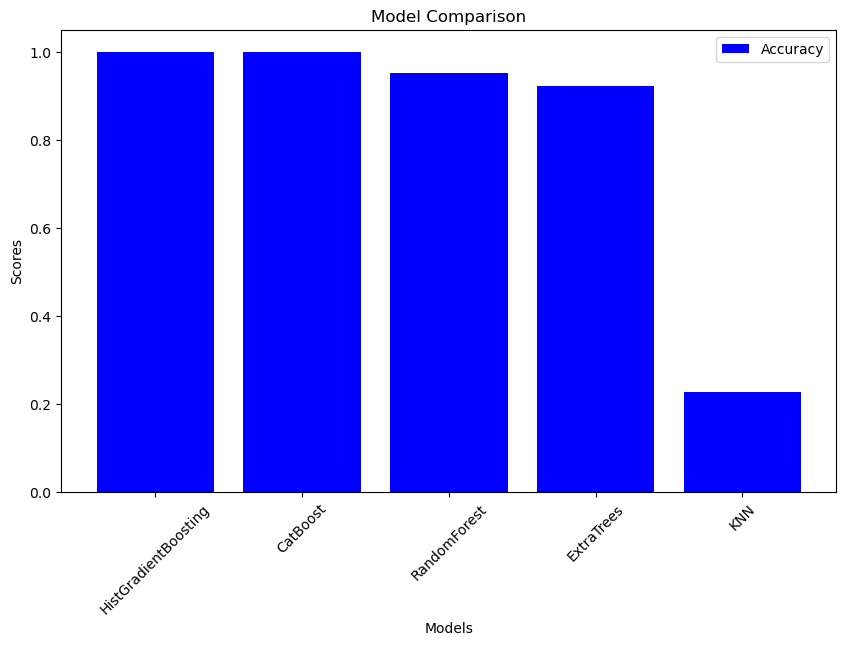

In [52]:
# Define the model names and corresponding scores
model_names = ['HistGradientBoosting', 'CatBoost', 'RandomForest', 'ExtraTrees', 'KNN']
accuracys = [accuracy_score(y_test, predictions), accuracy_score(y_test, predictions_catboost), accuracy_score(y_test, predictions_extratrees), accuracy_score(y_test, predictions_randomforest), accuracy_score(y_test, predictions_knn)]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracys, color='blue', label='Accuracy')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.legend()
plt.xticks(rotation=45)

plt.show()